<a href="https://colab.research.google.com/github/amFarrouk/OCR_prj/blob/main/simpleCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt
import zipfile

In [2]:
!wget https://raw.githubusercontent.com/amFarrouk/OCR_prj/main/bdh.zip
!unzip -qq ./bdh.zip 
!rm ./bdh.zip

--2021-12-10 00:59:51--  https://raw.githubusercontent.com/amFarrouk/OCR_prj/main/bdh.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7536168 (7.2M) [application/zip]
Saving to: ‘bdh.zip’

bdh.zip             100%[===================>]   7.19M  35.8MB/s    in 0.2s    

2021-12-10 00:59:53 (35.8 MB/s) - ‘bdh.zip’ saved [7536168/7536168]



In [3]:
!wget https://www.dropbox.com/s/qpagi0h1089kr2f/images_df.csv

--2021-12-10 00:59:54--  https://www.dropbox.com/s/qpagi0h1089kr2f/images_df.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/qpagi0h1089kr2f/images_df.csv [following]
--2021-12-10 00:59:54--  https://www.dropbox.com/s/raw/qpagi0h1089kr2f/images_df.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0127eebedc1c204f434a0ac2f4.dl.dropboxusercontent.com/cd/0/inline/BbjRih3RlUQwoIafU8oaHB1fS8PiD-FLKNF6Vz5Ze_U-dEETelNIES6x_b47XGKYJXM-mRDl4rGM2cmvi1jJrbjDj7wzwATMiC8V-F4tepLj3057ONN1M-aYJ7gRsBatUtWDx0NMN0Yi8yJqTMwkLkhk/file# [following]
--2021-12-10 00:59:55--  https://uc0127eebedc1c204f434a0ac2f4.dl.dropboxusercontent.com/cd/0/inline/BbjRih3RlUQwoIafU8oaHB1fS8PiD-FLKNF6Vz5Ze_U-dEETelNIES6x_b47XGKYJXM-mRDl4rGM2cmvi1jJ

In [4]:
images_df=pd.read_csv("./images_df.csv",header=None,names=["img","label"])
images_df["label"]=images_df["label"].apply(lambda x : str(x))
images_df.head()

,img,label
0,ae07_005.bmp,18
1,ae07_011.bmp,17
2,ae07_014.bmp,20
3,ae07_015.bmp,18
4,ae07_022.bmp,12


In [5]:
labels=images_df['label']
labels=labels.to_numpy()

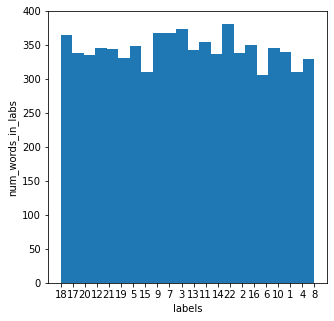

In [6]:
plt.figure(figsize=(5,5))
plt.xlim()
plt.xlabel("labels")
plt.ylabel("num_words_in_labs")
plt.hist(labels,bins=22)
plt.show()

In [7]:
img1=cv2.imread("./bdh/ae07_005.bmp",cv2.IMREAD_GRAYSCALE)
img2=cv2.imread("./bdh/ae07_031.bmp",cv2.IMREAD_GRAYSCALE)
img3=cv2.imread("./bdh/ae09_017.bmp",cv2.IMREAD_GRAYSCALE)
img4=cv2.imread("./bdh/ai64_020.bmp",cv2.IMREAD_GRAYSCALE)

Text(0.5, 0, 'ai64_020.bmp')

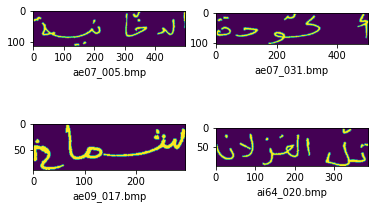

In [8]:
_, axarr = plt.subplots(2,2)

axarr[0,0].imshow(img1)
axarr[0,0].set_xlabel("ae07_005.bmp")
axarr[0,1].imshow(img2)
axarr[0,1].set_xlabel("ae07_031.bmp")
axarr[1,0].imshow(img3)
axarr[1,0].set_xlabel("ae09_017.bmp")
axarr[1,1].imshow(img4)
axarr[1,1].set_xlabel("ai64_020.bmp")

In [9]:
imgresize1 = cv2.resize(img1, (760, 120)) 
imgresize2 = cv2.resize(img2, (760, 120)) 
imgresize3 = cv2.resize(img3, (760, 120)) 
imgresize4 = cv2.resize(img4, (760, 120)) 

Text(0.5, 0, 'ai64_020.bmp')

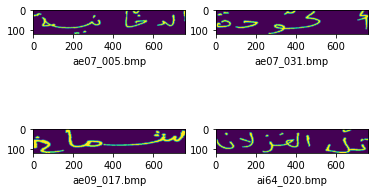

In [10]:
_, axarr = plt.subplots(2,2)
axarr[0,0].imshow(imgresize1)
axarr[0,0].set_xlabel("ae07_005.bmp")
axarr[0,1].imshow(imgresize2)
axarr[0,1].set_xlabel("ae07_031.bmp")
axarr[1,0].imshow(imgresize3)
axarr[1,0].set_xlabel("ae09_017.bmp")
axarr[1,1].imshow(imgresize4)
axarr[1,1].set_xlabel("ai64_020.bmp")

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
all_x,all_y=images_df["img"],images_df["label"]

xtrain,xtest,ytrain,ytest=train_test_split(all_x,all_y,train_size=0.8,random_state=1,shuffle=True)

train_df=pd.DataFrame(xtrain,columns=["img"])
train_df["label"]=ytrain

print("train_data:")
train_df.head()

train_data:


,img,label
5764,de12_032.bmp,16
7223,dm34_024.bmp,16
5124,cj14_066.bmp,13
5621,cq65_006.bmp,8
2624,bi06_006.bmp,16


In [13]:
test_df=pd.DataFrame(xtest,columns=["img"])
test_df["label"]=ytest

print("test_data:")
test_df.head()

test_data:


,img,label
3069,bj01_033.bmp,3
642,af62_017.bmp,22
7266,dq06_018.bmp,8
5765,de12_034.bmp,16
2229,be92_023.bmp,13


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
train_image_gen=ImageDataGenerator(rescale=1.0/255)
test_image_gen=ImageDataGenerator(rescale=1.0/255)

In [16]:
train_image_gen=train_image_gen.flow_from_dataframe(train_df,x_col="img",y_col="label",
                                            directory="./bdh",
                                            batch_size=32,
                                            target_size=(imgresize1.shape[0],imgresize1.shape[1]),
                                            color_mode='grayscale',
                                            class_mode='categorical')

Found 6048 validated image filenames belonging to 22 classes.


In [17]:
test_image_gen=test_image_gen.flow_from_dataframe(test_df,x_col="img",y_col="label",
                                            directory="./bdh",
                                            batch_size=32,
                                            target_size=(imgresize1.shape[0],imgresize1.shape[1]),
                                            color_mode='grayscale',
                                            class_mode='categorical')

Found 1512 validated image filenames belonging to 22 classes.


In [18]:
import tensorflow as tf

In [19]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 760x120 with 1 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(760, 120, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 128 neuron hidden layer
    tf.keras.layers.Dense(128, activation='relu'),
    # Only 22 output neuron.
    tf.keras.layers.Dense(22, activation='softmax')
])

In [20]:
loss=tf.keras.losses.categorical_crossentropy
optim=tf.keras.optimizers.Adam()
myCallBack=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4)

model.compile(optimizer=optim, loss=loss, metrics=['accuracy'])

In [21]:
_=tf.keras.utils.plot_model(
    model, to_file='./simpleCNN1.png', show_shapes=True, show_layer_names=False,
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 758, 118, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 379, 59, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 377, 57, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 188, 28, 64)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 186, 26, 64)       36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 93, 13, 64)       0

In [22]:
history=model.fit(train_image_gen,epochs=100,steps_per_epoch=189,validation_data=test_image_gen,callbacks=[myCallBack])

Epoch 1/100
189/189 [==============================] - 44s 165ms/step - loss: 0.6559 - accuracy: 0.8072 - val_loss: 0.2157 - val_accuracy: 0.9259
Epoch 2/100
189/189 [==============================] - 31s 162ms/step - loss: 0.0932 - accuracy: 0.9688 - val_loss: 0.2156 - val_accuracy: 0.9312
Epoch 3/100
189/189 [==============================] - 30s 161ms/step - loss: 0.0298 - accuracy: 0.9889 - val_loss: 0.2187 - val_accuracy: 0.9365
Epoch 4/100
189/189 [==============================] - 30s 161ms/step - loss: 0.0353 - accuracy: 0.9886 - val_loss: 0.1531 - val_accuracy: 0.9544
Epoch 5/100
189/189 [==============================] - 30s 161ms/step - loss: 0.0202 - accuracy: 0.9931 - val_loss: 0.1833 - val_accuracy: 0.9511
Epoch 6/100
189/189 [==============================] - 30s 161ms/step - loss: 0.0131 - accuracy: 0.9959 - val_loss: 0.1960 - val_accuracy: 0.9425
Epoch 7/100
189/189 [==============================] - 30s 161ms/step - loss: 0.0224 - accuracy: 0.9926 - val_loss: 0.1987 -

In [39]:
#-----------------------------------------------------------------------
# Retrieve a list of list results on training and test data of 1st model
# sets for each training epoch
#-----------------------------------------------------------------------
acc_hist=history.history['accuracy']
val_acc_hist=history.history['val_accuracy']
loss_hist=history.history['loss']
val_loss_hist=history.history['val_loss']

epochs=range(len(acc_hist)) # Get number of epochs

In [24]:
model2 = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(760, 120, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Only 22 output neuron.
    tf.keras.layers.Dense(22, activation='softmax')
])

In [25]:
loss=tf.keras.losses.categorical_crossentropy
optim=tf.keras.optimizers.Adam()
myCallBack=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4)

model2.compile(optimizer=optim, loss=loss, metrics=['accuracy'])

In [26]:
history2=model2.fit(train_image_gen,epochs=100,steps_per_epoch=189,validation_data=test_image_gen,callbacks=[myCallBack])

Epoch 1/100
189/189 [==============================] - 68s 340ms/step - loss: 0.5830 - accuracy: 0.8271 - val_loss: 0.1453 - val_accuracy: 0.9497
Epoch 2/100
189/189 [==============================] - 63s 334ms/step - loss: 0.0817 - accuracy: 0.9727 - val_loss: 0.1277 - val_accuracy: 0.9616
Epoch 3/100
189/189 [==============================] - 63s 335ms/step - loss: 0.0288 - accuracy: 0.9894 - val_loss: 0.1635 - val_accuracy: 0.9544
Epoch 4/100
189/189 [==============================] - 63s 335ms/step - loss: 0.0244 - accuracy: 0.9919 - val_loss: 0.1811 - val_accuracy: 0.9405
Epoch 5/100
189/189 [==============================] - 63s 335ms/step - loss: 0.0334 - accuracy: 0.9899 - val_loss: 0.1271 - val_accuracy: 0.9649
Epoch 6/100
189/189 [==============================] - 63s 334ms/step - loss: 0.0265 - accuracy: 0.9912 - val_loss: 0.1278 - val_accuracy: 0.9597
Epoch 7/100
189/189 [==============================] - 63s 334ms/step - loss: 0.0087 - accuracy: 0.9972 - val_loss: 0.1403 -

In [41]:
#-----------------------------------------------------------------------
# Retrieve a list of list results on training and test data of 2nd model
# sets for each training epoch
#-----------------------------------------------------------------------
acc2_hist=history2.history['accuracy']
val_acc2_hist=history2.history['val_accuracy']
loss2_hist=history2.history['loss']
val_loss2_hist=history2.history['val_loss']

epochs2=range(len(acc2_hist)) # Get number of epochs

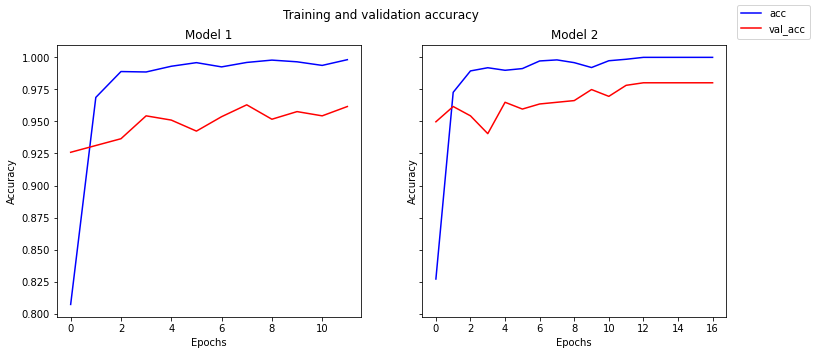

In [43]:
#----------------------------------------------------------------
# Plot training and validation accuracy per epoch for both models
#----------------------------------------------------------------
fig, (axs1, axs2) = plt.subplots(1, 2,figsize=(12,5),sharey=True)
fig.suptitle('Training and validation accuracy')

axs1.set_title('Model 1')
axs1.set(xlabel="Epochs",ylabel="Accuracy")
axs1.plot(epochs, acc_hist,'b',label="acc")
axs1.plot(epochs, val_acc_hist,'r',label="val_acc")

axs2.set_title('Model 2')
axs2.set(xlabel="Epochs",ylabel="Accuracy")
axs2.plot(epochs2, acc2_hist,'b')
axs2.plot(epochs2, val_acc2_hist,'r')

fig.legend(loc="upper right")
plt.show()

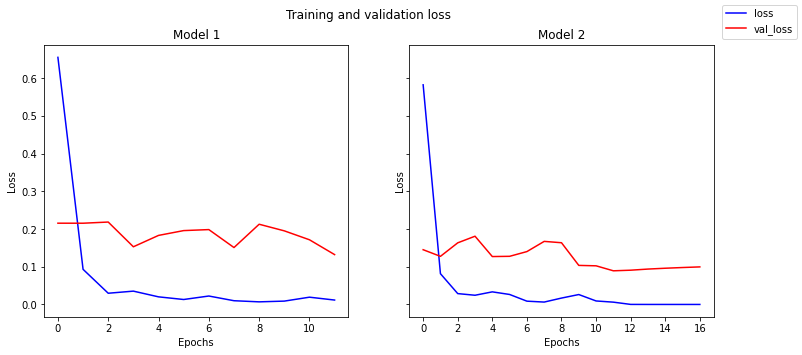

In [44]:
#----------------------------------------------------------------
# Plot training and validation accuracy per epoch for both models
#----------------------------------------------------------------
fig, (axs1, axs2) = plt.subplots(1, 2,figsize=(12,5),sharey=True)
fig.suptitle('Training and validation loss')

axs1.set_title('Model 1')
axs1.set(xlabel="Epochs",ylabel="Loss")
axs1.plot(epochs, loss_hist,'b',label="loss")
axs1.plot(epochs, val_loss_hist,'r',label="val_loss")

axs2.set_title('Model 2')
axs2.set(xlabel="Epochs",ylabel="Loss")
axs2.plot(epochs2, loss2_hist,'b')
axs2.plot(epochs2, val_loss2_hist,'r')

fig.legend(loc="upper right")
plt.show()